In [1]:
'''
Energy model compared with measurement data
Unit: mm
Author: Yitian Shao
Created on 2021.01.15
'''
%matplotlib notebook 
%matplotlib notebook 

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

In [2]:
'''
General Functions
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (10,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

In [11]:
pouchStructure = np.array([6, 5, 4, 3, 2, 1])
rectNum = np.sum(pouchStructure - 1) # Number of rectangle pouch-cell
triNum = rectNum*2 - len(pouchStructure) +1 # Number of triangle pouch-cell
print("Pouch contains totally %d rectangle and %d triangle" % (rectNum, triNum))

Pouch contains totally 15 rectangle and 25 triangle


In [12]:
DATA_PATH = "./data/PouchModelData.csv"
data = pd.read_csv(DATA_PATH)
print("Data contains %d rows and %d columns" % data.shape)

data.head(1)

Data contains 300 rows and 11 columns


,dashHalfDist,dashSpace,R,triArc,triFA,triPSA,triVol,rectVol,triCapa,rectCapa,dashLength
0,5,8.66,10.0,10.52149,9.54294,9.542546,60.752613,152.687043,4.831083e-13,3.974376e-12,16


In [16]:
'''
Additional Computation for the whole pouch 
'''
totalVol = (triNum * data['triVol'] + rectNum * data['rectVol']) # (mm3)
totalLength = (data['dashSpace'] + data['dashLength']) * pouchStructure.size # (mm)
totalWidth = data['dashHalfDist'] * 2 * (np.amax(pouchStructure) + 1) # (mm)

triArea = data['dashSpace'] * data['dashHalfDist'] # (mm2) Top-view area of a triangle pouch (Not surface area)
rectArea = 2 * data['dashHalfDist'] * data['dashLength'] # (mm2) Top-view area of a rectangle pouch (Not surface area)

totalCapa = (triNum * data['triCapa'] + rectNum * data['rectCapa']) # (Farad)

<IPython.core.display.Javascript object>


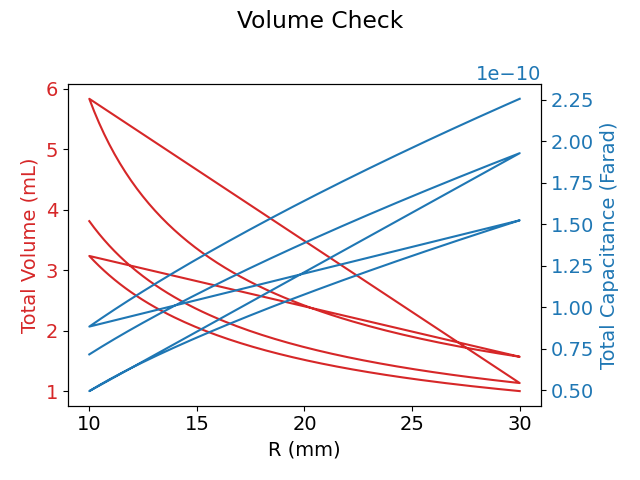

In [21]:
fig1, ax1 = plt.subplots()
fig1.suptitle("Volume Check")
ax1.set_xlabel('R (mm)')

ax1.plot(data['R'], totalVol/1000, color='tab:red')
ax1.set_ylabel('Total Volume (mL)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.plot(data['R'], totalCapa, color='tab:blue')
ax2.set_ylabel('Total Capacitance (Farad)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig1.tight_layout() 